# Importación de Base de Datos

## Librerías

In [177]:
import pandas as pd
from prophet import Prophet
import plotly.graph_objs as go
import numpy as np
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
import routes

## Creación de dataframes

### Importación de los datos crudos

In [6]:
# Se cargan los archivos de excel
dfAdmitidos = pd.read_excel(routes.path_admitidos)
dfMatprimer = pd.read_excel(routes.path_matprimer)
dfInscritos = pd.read_excel(routes.path_inscritos, sheet_name='Inscritos')

In [7]:
# Se normaliza el nombre de las columnas
dfInscritos.columns = [col.replace('\n', ' ') for col in dfInscritos.columns]
dfInscritos.columns = dfInscritos.columns.str.upper()

### Agregación de Semestre y Género

#### Admitidos

In [85]:
group_columns = [
    'CÓDIGO DE LA INSTITUCIÓN', 'IES PADRE',
    'INSTITUCIÓN DE EDUCACIÓN SUPERIOR (IES)', 'PRINCIPAL O SECCIONAL',
    'SECTOR IES', 'CARACTER IES', 'CÓDIGO DEL DEPARTAMENTO (IES)',
    'DEPARTAMENTO DE DOMICILIO DE LA IES', 'CÓDIGO DEL MUNICIPIO IES',
    'MUNICIPIO DE DOMICILIO DE LA IES', 'CÓDIGO SNIES DEL PROGRAMA',
    'PROGRAMA ACADÉMICO', 'NIVEL ACADÉMICO', 'NIVEL DE FORMACIÓN',
    'METODOLOGÍA', 'CÓDIGO DEL DEPARTAMENTO (PROGRAMA)',
    'DEPARTAMENTO DE OFERTA DEL PROGRAMA', 'CÓDIGO DEL MUNICIPIO (PROGRAMA)',
    'MUNICIPIO DE OFERTA DEL PROGRAMA', 'AÑO', 'SEMESTRE'   # Include AÑO to aggregate per year
]

# Group by the defined columns and sum the 'ADMITIDOS'
aggregated_dfAdmitidos = dfAdmitidos.groupby(group_columns, as_index=False)['ADMITIDOS'].sum()


#### Primer Curso

In [86]:
group_columns = [
    'CÓDIGO DE LA INSTITUCIÓN', 'IES_PADRE',
    'INSTITUCIÓN DE EDUCACIÓN SUPERIOR (IES)', 'PRINCIPAL O SECCIONAL',
    'SECTOR IES', 'CARACTER IES', 'CÓDIGO DEL DEPARTAMENTO (IES)',
    'DEPARTAMENTO DE DOMICILIO DE LA IES', 'CÓDIGO DEL MUNICIPIO (IES)',
    'MUNICIPIO DE DOMICILIO DE LA IES', 'CÓDIGO SNIES DEL PROGRAMA',
    'PROGRAMA ACADÉMICO', 'NIVEL ACADÉMICO', 'NIVEL DE FORMACIÓN',
    'METODOLOGÍA', 'CÓDIGO DEL DEPARTAMENTO (PROGRAMA)',
    'DEPARTAMENTO DE OFERTA DEL PROGRAMA', 'CÓDIGO DEL MUNICIPIO (PROGRAMA)',
    'MUNICIPIO DE OFERTA DEL PROGRAMA', 'AÑO', 'SEMESTRE'   # Include AÑO to aggregate per year
]

# Group by the defined columns and sum the 'PRIMER CURSO'
aggregated_dfMatprimer = dfMatprimer.groupby(group_columns, as_index=False)['PRIMER CURSO'].sum()

#### Inscritos

In [87]:
group_columns = [
    'CÓDIGO DE  LA INSTITUCIÓN', 'IES PADRE',
       'INSTITUCIÓN DE EDUCACIÓN SUPERIOR', 'PRINCIPAL  O  SECCIONAL',
       'SECTOR IES', 'CARACTER IES', 'CÓDIGO DEL  DEPARTAMENTO (IES)',
       'DEPARTAMENTO DE  DOMICILIO DE LA IES', 'CÓDIGO DEL  MUNICIPIO (IES)',
       'MUNICIPIO DE DOMICILIO DE LA IES', 'CÓDIGO  SNIES DEL PROGRAMA',
       'PROGRAMA ACADÉMICO', 'NIVEL ACADÉMICO', 'NIVEL DE FORMACIÓN',
       'METODOLOGÍA', 'CÓDIGO DEL  DEPARTAMENTO (PROGRAMA)',
       'DEPARTAMENTO DE OFERTA DEL PROGRAMA',
       'CÓDIGO DEL  MUNICIPIO (PROGRAMA)', 'SEMESTRE' ,'MUNICIPIO DE OFERTA DEL PROGRAMA',
       'AÑO'  # Include AÑO to aggregate per year
]

# Group by the defined columns and sum the 'ADMITIDOS'
aggregated_dfInscritos = dfInscritos.groupby(group_columns, as_index=False)['INSCRITOS'].sum()

# Creación de modelo

### Exploración de relaciones

In [169]:
aggregated_dfMatprimer.columns

Index(['CÓDIGO DE LA INSTITUCIÓN', 'IES_PADRE',
       'INSTITUCIÓN DE EDUCACIÓN SUPERIOR (IES)', 'PRINCIPAL O SECCIONAL',
       'SECTOR IES', 'CARACTER IES', 'CÓDIGO DEL DEPARTAMENTO (IES)',
       'DEPARTAMENTO DE DOMICILIO DE LA IES', 'CÓDIGO DEL MUNICIPIO (IES)',
       'MUNICIPIO DE DOMICILIO DE LA IES', 'CÓDIGO SNIES DEL PROGRAMA',
       'PROGRAMA ACADÉMICO', 'NIVEL ACADÉMICO', 'NIVEL DE FORMACIÓN',
       'METODOLOGÍA', 'CÓDIGO DEL DEPARTAMENTO (PROGRAMA)',
       'DEPARTAMENTO DE OFERTA DEL PROGRAMA',
       'CÓDIGO DEL MUNICIPIO (PROGRAMA)', 'MUNICIPIO DE OFERTA DEL PROGRAMA',
       'AÑO', 'SEMESTRE', 'PRIMER CURSO', 'DATE'],
      dtype='object')

In [139]:
aggregated_dfMatprimer['AÑO'] = pd.to_datetime(aggregated_dfMatprimer['AÑO'], format='%Y')
aggregated_dfMatprimer['DATE'] = aggregated_dfMatprimer.apply(
    lambda row: row['AÑO'] + pd.DateOffset(months=6*(row['SEMESTRE']-1)),
    axis=1
)

In [140]:
program_df = aggregated_dfMatprimer.groupby(['DATE', 'CÓDIGO SNIES DEL PROGRAMA']).agg({'PRIMER CURSO': 'sum'}).reset_index()

In [162]:
# Aggregate the 'PRIMER CURSO' per year and program
program_df = aggregated_dfMatprimer.groupby(['DATE', 'CÓDIGO SNIES DEL PROGRAMA']).agg({'PRIMER CURSO': 'sum'}).reset_index()

# Create a new DataFrame for Prophet forecasting for a specific product (example: 100)
program_df = program_df[program_df['CÓDIGO SNIES DEL PROGRAMA'] == 2].copy()
program_df ['ds'] = program_df['DATE']
program_df['y'] = program_df['PRIMER CURSO']
program_df = program_df[['ds', 'y']]

### Holts-Winters

In [176]:
# Fit model
model = ExponentialSmoothing(program_df['y'], trend="add", seasonal="add", seasonal_periods=2)
model_fit = model.fit()

# Forecast next few periods
forecast = model_fit.forecast(steps=4)
print(forecast)

18    48.347222
19    53.347222
20    48.238889
21    53.238888
dtype: float64


c:\Users\JUAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\JUAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\JUAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [184]:
n_splits = 3  # for simplicity, assuming we want 3 validation points

# Initialize lists to store the performance of each fold
mse_scores = []
mae_scores = []

# The minimum number of observations we decide is needed to start forecasting
min_train_size = 6

for t in range(min_train_size, len(program_df) - n_splits + 1):
    train = program_df.iloc[:t]
    test = program_df.iloc[t:t+n_splits]  # here n_splits is 1 for one-step ahead prediction
    
    # Fit model
    model = ExponentialSmoothing(program_df['y'], seasonal='add', seasonal_periods=4)
    model_fit = model.fit()
    
    # Forecast
    forecast = model_fit.forecast(steps=n_splits)
    
    # Calculate performance metrics
    mse = mean_squared_error(test['y'], forecast)
    mae = mean_absolute_error(test['y'], forecast)
    
    # Store the scores
    mse_scores.append(mse)
    mae_scores.append(mae)

# Print average scores
print(f'Average MSE: {np.mean(mse_scores)}')
print(f'Average MAE: {np.mean(mae_scores)}')

Average MSE: 38.6275002887143
Average MAE: 4.95999997427646


c:\Users\JUAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\JUAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\JUAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

c:\Users\JUAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\JUAN\AppData\Local\Programs\Python\Python311

### Modelo Prophet

In [185]:
program_df

,ds,y
1,2014-01-01,41
6583,2014-07-01,51
12806,2015-01-01,59
19546,2015-07-01,67
26198,2016-01-01,48
34043,2016-07-01,47
41522,2017-01-01,48
49713,2017-07-01,52
57372,2018-01-01,57
65794,2018-07-01,53


In [164]:

# Create and fit the Prophet model
model = Prophet()
model.fit(program_df)

# Make future predictions
future = model.make_future_dataframe(periods=6, freq='6M')

# Identify the last historical date in the original dataset
last_hist_date = program_df['ds'].max()

# Adjust only the future prediction dates to start at the beginning of a month
future.loc[future['ds'] > last_hist_date, 'ds'] = future['ds'][future['ds'] > last_hist_date] + pd.offsets.MonthBegin(-1)

forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

11:30:51 - cmdstanpy - INFO - Chain [1] start processing
11:30:51 - cmdstanpy - INFO - Chain [1] done processing


           ds       yhat  yhat_lower  yhat_upper
0  2014-01-01  48.829580   42.723564   55.653088
1  2014-07-01  55.428026   48.859471   61.501705
2  2015-01-01  49.009219   42.660749   54.941286
3  2015-07-01  59.136754   53.159321   65.122209
4  2016-01-01  48.954392   43.006979   54.994261
5  2016-07-01  48.120688   42.177647   54.427474
6  2017-01-01  48.510576   42.243085   54.920674
7  2017-07-01  51.817525   45.642707   57.893766
8  2018-01-01  48.923869   42.762583   55.269487
9  2018-07-01  55.522215   49.147140   61.360132
10 2019-01-01  49.103306   42.545106   54.869486
11 2019-07-01  59.230741   53.000396   65.930848
12 2020-01-01  49.048378   42.965292   55.212248
13 2020-07-01  48.214674   42.169798   54.584279
14 2021-01-01  48.604562   41.792277   54.483423
15 2021-07-01  51.911511   46.028230   58.008291
16 2022-01-01  49.017855   43.056966   55.337130
17 2022-07-01  55.616201   49.335061   61.584691
18 2022-07-01  55.616201   49.400852   61.710335
19 2023-01-01  49.19

c:\Users\JUAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\JUAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



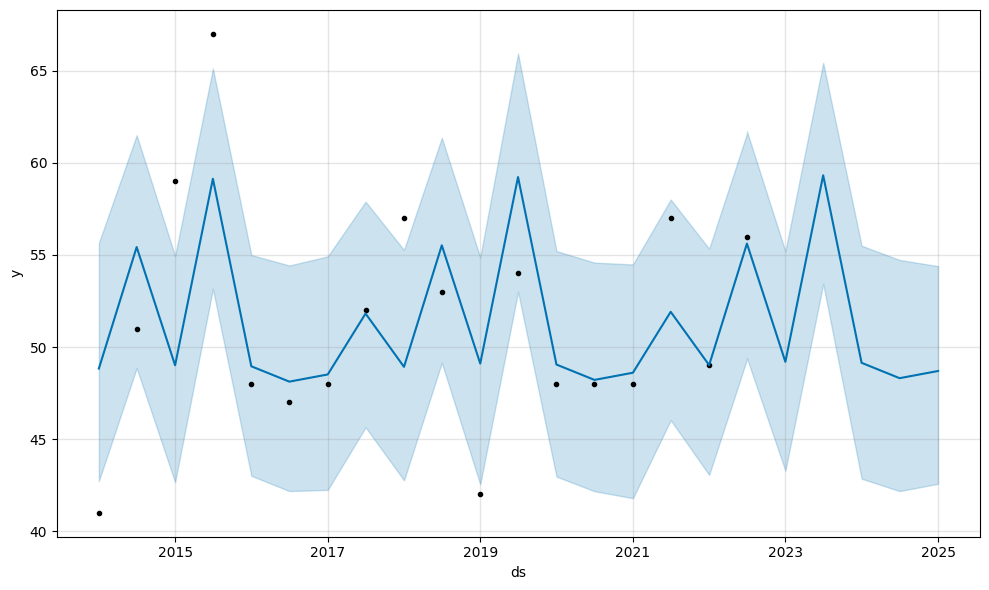

In [165]:
fig = model.plot(forecast)

In [166]:
# Plotting with Plotly
trace1 = go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Prediction')
trace2 = go.Scatter(x=program_df['ds'], y=program_df['y'], mode='lines+markers', name='Actual Data')
layout = go.Layout(title='Academic Program Demand Forecast', xaxis_title='Date', yaxis_title='Quantity')
fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [168]:
df_cv = cross_validation(model, initial='1460 days', period='365 days', horizon='730 days')

# Calcular las métricas de rendimiento
df_p = performance_metrics(df_cv)

# Mostrar las métricas de rendimiento
print(df_p)

  0%|          | 0/3 [00:00<?, ?it/s]11:31:03 - cmdstanpy - INFO - Chain [1] start processing
11:31:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  5.85it/s]11:31:04 - cmdstanpy - INFO - Chain [1] start processing
11:31:04 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  5.27it/s]11:31:04 - cmdstanpy - INFO - Chain [1] start processing
11:31:04 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  5.31it/s]

   horizon         mse       rmse        mae      mape     mdape     smape  \
0 183 days   91.414706   9.561104   6.930136  0.164493  0.164493  0.142200   
1 184 days    0.519725   0.720919   0.720919  0.015019  0.015019  0.015133   
2 364 days  157.803311  12.561979  12.561979  0.232629  0.232629  0.208390   
3 365 days   34.685078   5.889404   5.564846  0.103610  0.103610  0.109726   
4 548 days  101.096496  10.054675  10.054675  0.209472  0.209472  0.189613   
5 549 days    2.673587   1.635111   1.631967  0.033631  0.033631  0.034208   
6 730 days   30.544433   5.526702   4.506308  0.081088  0.053531  0.085869   

   coverage  
0  0.500000  
1  1.000000  
2  0.000000  
3  0.500000  
4  0.000000  
5  1.000000  
6  0.666667  
